In [1]:
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 
import matplotlib.gridspec as gridspec
import os 
import glob
import re
import nc_time_axis
import time 

def scientific_formatter(x, pos):
    if x == 0:
        return "$0$"
    exponent = int(np.floor(np.log10(x)))
    base = round(x / 10**exponent)
    if base == 1:
        return f"$10^{{{exponent}}}$"
    else:
        return f"${base} \\times 10^{{{exponent}}}$"


/tmp/ipykernel_261028/2713065812.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


# Raw code

In [ ]:
testpath = f'/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h0.0001-01.nc'
testfile = xr.open_dataset(testpath, decode_times=False)
testfile

In [ ]:
# lat_bins = np.arange(-90, 95, 5)  # Ensures full 5-degree bins

# # Compute bin labels (midpoints of bins)
# lat_bin_labels = (lat_bins[:-1] + lat_bins[1:]) / 2  # Midpoints of bins

# # Assign each latitude value to a bin index
# lat_bin_indices = np.digitize(med_Fe.lat, lat_bins, right=False) - 1
# lat_bin_indices = np.clip(lat_bin_indices, 0, len(lat_bin_labels) - 1)

# # Convert bin indices to bin midpoints
# latitude_bins = xr.DataArray(lat_bin_labels[lat_bin_indices], coords={"lat": med_Fe.lat}, dims="lat")

# # Add the latitude bins as a new coordinate
# med_Fe = med_Fe.assign_coords(latitude_bins=latitude_bins)

# print(med_Fe)

In [ ]:
# lat_bins = np.arange(-90, 95, 5)  # Ensures full 5-degree bins
# lat_bin_labels = (lat_bins[:-1] + lat_bins[1:]) / 2  # Midpoints of bins

# # Group by latitude bins and average across lat and longitude
# binned_Fe = (
#     med_Fe.groupby_bins("lat", lat_bins, labels=lat_bin_labels)
#     .mean(dim=["lat", "lon"])  # Average over latitudes and longitudes
# )

# # Reset dimension name by converting `lat_bins` to `lat`
# binned_Fe = binned_Fe.rename({"lat_bins": "lat"})

# # Ensure `lat` is a proper coordinate
# binned_Fe = binned_Fe.assign_coords(lat=("lat", binned_Fe.lat.values))

# print(binned_Fe)

In [ ]:
# fig, ax = plt.subplots()

# ax.plot(binned_Fe['lat'], binned_Fe)

# plt.show()

In [ ]:
# ds = xr.open_dataset(testpath, decode_times=False)
# ds = ds['Fe'].sel(time=31)
# ds = np.sum(ds, axis = 0)

# lat_bins = np.arange(-90, 95, 5)  # Ensures full 5-degree bins
# lat_bin_labels = (lat_bins[:-1] + lat_bins[1:]) / 2  # Midpoints of bins

# binned = (
#         ds.groupby_bins("lat", lat_bins, labels=lat_bin_labels).mean(dim=["lat", "lon"])  # Average over latitudes and longitudes
#               )

# # Reset dimension name by converting `lat_bins` to `lat`
# binned = binned.rename({"lat_bins": "lat"})

# # Ensure `lat` is a proper coordinate
# binned = binned.assign_coords(lat=("lat", binned.lat.values))
# binned

In [ ]:
# value = binned.mean(dim='lat')
# value = value.item()
# value

Now need to add into new dataset combined with all the other months 

# Function

In [49]:
def metal_layer_month(filepath, metal):

    ds = xr.open_dataset(filepath, decode_times=False)
    ds = ds[metal].sel(time=ds['time'][-1].item())
    ds = np.sum(ds, axis = 0)

    lat_bins = np.arange(-90, 95, 5)  # Ensures full 5-degree bins
    lat_bin_labels = (lat_bins[:-1] + lat_bins[1:]) / 2  # Midpoints of bins

    binned = (
            ds.groupby_bins("lat", lat_bins, labels=lat_bin_labels).mean(dim=["lat", "lon"])
                )

    # Reset dimension name by converting `lat_bins` to `lat`
    binned = binned.rename({"lat_bins": "lat"})

    # Ensure `lat` is a proper coordinate
    binned = binned.assign_coords(lat=("lat", binned.lat.values))
    value = binned.mean(dim='lat')
    value = value.item()
    value
    return value

In [50]:
def metal_layer_year(run_name):
    months = {1,2,3,4,5,6,7,8,9,10,11,12}
    year_data = []  # Dictionary to store month-value pairs

    for month in months:
        
        month_str = f"{month:02}"
        
        if run_name == 'Solar Med':
            filepath = f'/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h0.0001-{month_str}.nc'

        elif run_name == 'Solar Max':
            filepath = f'/resstore/b0243/Data/Sporadic_E/Solar_Max/archive_yr2000/atm/hist/SMax_3M_FX2000_f19f19mg16.cam.h0.0001-{month_str}.nc'
    
        elif run_name == 'Solar Min':
            filepath = f'/resstore/b0243/Data/Sporadic_E/Solar_Min/archive_yr2000/atm/hist/SMin_3M_FX2000_f19f19mg16.cam.h0.0001-{month_str}.nc'

        elif run_name == 'Climate Change':
            filepath = f'/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-{month_str}.nc'
    
        month_avg =  metal_layer_month(filepath, metal)
        print(month_avg)  
        year_data.append(month_avg)

    return year_data    

In [51]:
metal = 'Fe'
run_name = 'Solar Med' # # OR # 'Solar Med'
                            # 'Solar Max'
                            # 'Solar Min'
                            # 'Climate Change'

In [52]:
med_Fe_avg = metal_layer_year(run_name)
print(med_Fe_avg)

1.3682257549163523e-09
1.5711859591149846e-09
1.4532470782313567e-09
1.3353467220866833e-09
1.479323663566845e-09
1.5165444455789157e-09
1.5980134993043293e-09
1.5223188265522936e-09
1.492971635208562e-09
1.3563113965275875e-09
1.4584461416333738e-09
1.5343355475039289e-09
[1.3682257549163523e-09, 1.5711859591149846e-09, 1.4532470782313567e-09, 1.3353467220866833e-09, 1.479323663566845e-09, 1.5165444455789157e-09, 1.5980134993043293e-09, 1.5223188265522936e-09, 1.492971635208562e-09, 1.3563113965275875e-09, 1.4584461416333738e-09, 1.5343355475039289e-09]


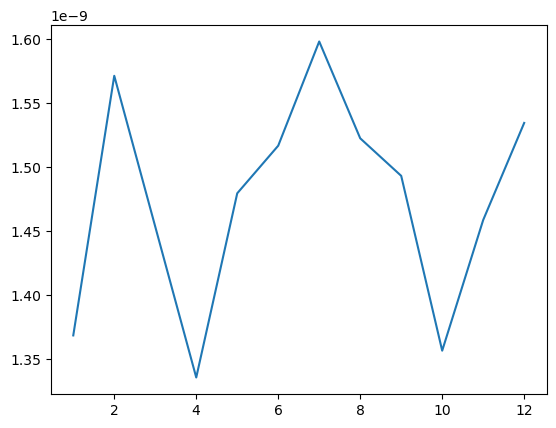

In [54]:
fig, ax = plt.subplots() 

ax.plot(months, med_Fe_avg)

plt.show()